In [ ]:
import sys

sys.path.insert(0, "..")

import matplotlib.pyplot as plt
import seaborn as sns

# Our modules
from src.agents.dqn_agent import DQNAgent
from src.mdp import RewardFunction, State
from src.agents.callbacks.learning_curve_callback import LearningCurveCallback
from src.agents.metrics import TrainingMetrics, EvaluationMetrics
from src.seeds import generate_seeds

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# Initialize plot classes
training_plots = TrainingMetrics()
evaluation_plots = EvaluationMetrics()

## 2. Environment Setup

Create training and evaluation environments using the factory from `src.environment`.

**Key considerations:**
- Use `VecNormalize` for running mean-variance normalization
- Separate seeds for train/eval to avoid overfitting
- Sync normalization statistics between train and eval environments

In [2]:
# Configuration
EPISODE_LENGTH = 365  # days

TRAINING_SEED = generate_seeds(1, start_index=20)[0]
EVAL_SEED = generate_seeds(1, start_index=21)[0]
EVAL_SEEDS = generate_seeds(100, start_index=100)

print("🎲 DQN Training Seeds (DETERMINISTIC):")
print(f"   Training: {TRAINING_SEED}")
print(f"   Validation: {EVAL_SEED}")
print(f"   Final evaluation: {len(EVAL_SEEDS)} seeds starting at {EVAL_SEEDS[0]}")

🎲 DQN Training Seeds (DETERMINISTIC):
   Training: 6173
   Validation: 29
   Final evaluation: 100 seeds starting at 2216


In [3]:
from src.environment.gym_env import InventoryEnvironment


def make_env(
    episode_length: int = EPISODE_LENGTH,
    random_seed: int = TRAINING_SEED,
) -> InventoryEnvironment:
    return InventoryEnvironment(
        episode_length=episode_length,
        random_seed=random_seed,
    )


env = make_env(random_seed=TRAINING_SEED)
print(env)

Inventory Management Gym Environment (k=32, Q_max=42, episode_length=365)


## 3. Create and Train DQN Agent

**Hyperparameter choices:**
- `learning_rate`: [1e-5, 1e-3] - use 1e-4 as conservative start
- `gamma`: [0.95, 0.999] - use 0.99 for ~100 day horizon
- `buffer_size`: Large enough for decorrelation
- `exploration_fraction`: 30% of training for ε-decay

In [ ]:
# Create DQN Agent with deterministic seed
agent = DQNAgent(
    env=env,
    learning_rate=1e-5,
    gamma=0.99,  # High gamma for farsighted planning
    buffer_size=100_000,
    batch_size=64,
    exploration_fraction=0.4,  # 40% of training for exploration
    exploration_final_eps=0.05,
    target_update_interval=1000,
    learning_starts=1000,
    train_freq=4,
    tensorboard_log=None,  # Disable TensorBoard
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=TRAINING_SEED,
    verbose=0,
)

print(f"✅ DQN Agent created with seed {TRAINING_SEED}")

✅ DQN Agent created with seed 6173


## 5. Training

Train the DQN agent with periodic evaluation.

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=./logs
```

In [5]:
# Training parameters
TOTAL_TIMESTEPS = 1_000_000

print(f"🚀 Starting training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"   ≈ {TOTAL_TIMESTEPS // EPISODE_LENGTH:,} episodes\n")

learning_curve_callback = LearningCurveCallback()

# Train the agent with callback
agent.train(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True,
    callbacks=learning_curve_callback,
)

print(f"\n✅ Training complete!")
print(f"   Episodes recorded: {len(learning_curve_callback.episode_rewards)}")

Output()

🚀 Starting training for 1,000,000 timesteps...
   ≈ 2,739 episodes




✅ Training complete!
   Episodes recorded: 2739


## 6. Save the Trained Model

In [6]:
agent.save()

DQN weights saved to models


---
# Phase 1: Training Analysis


### 1. Learning Curve (Training Stability)
Average Reward per Episode vs. Timesteps with baseline comparison.


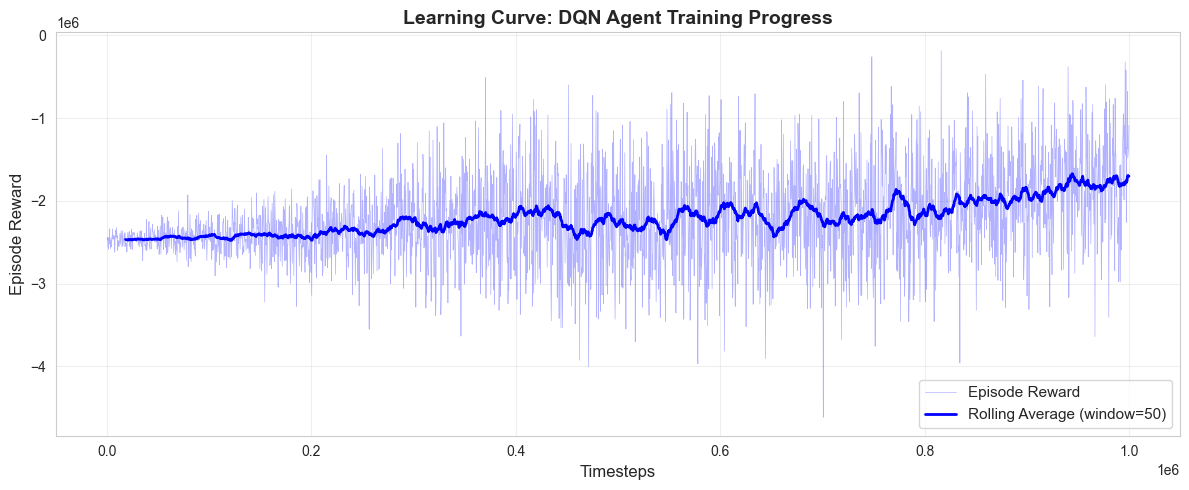

📊 Training Statistics:
  Total Episodes: 2739
  Total Timesteps: 999735
  Episode Length: 365.00 timesteps

  -- Performance (Last 50 episodes) --
  Mean Reward:   -1700946.88 ± 622163.38
  Min Reward:    -2980828.00
  Max Reward:    -321167.00

  -- Specifics --
  Best Ever Reward: -183885.00
  Last Ep Reward:   -1086835.00

 -- Daily Rewards --
  Mean Reward per Day: -6043.63 ± 1498.90
  Final Mean Reward per Day (last 50 eps): -4660.13 ± 1704.56


In [7]:
# Learning Curve: Use data from callback
training_plots.plot_learning_curve(
    episode_timesteps=learning_curve_callback.episode_timesteps,
    episode_rewards=learning_curve_callback.episode_rewards,
    window=50,
    title="Learning Curve: DQN Agent Training Progress",
)

### 2. Exploration vs Exploitation
Epsilon decay over training timesteps.


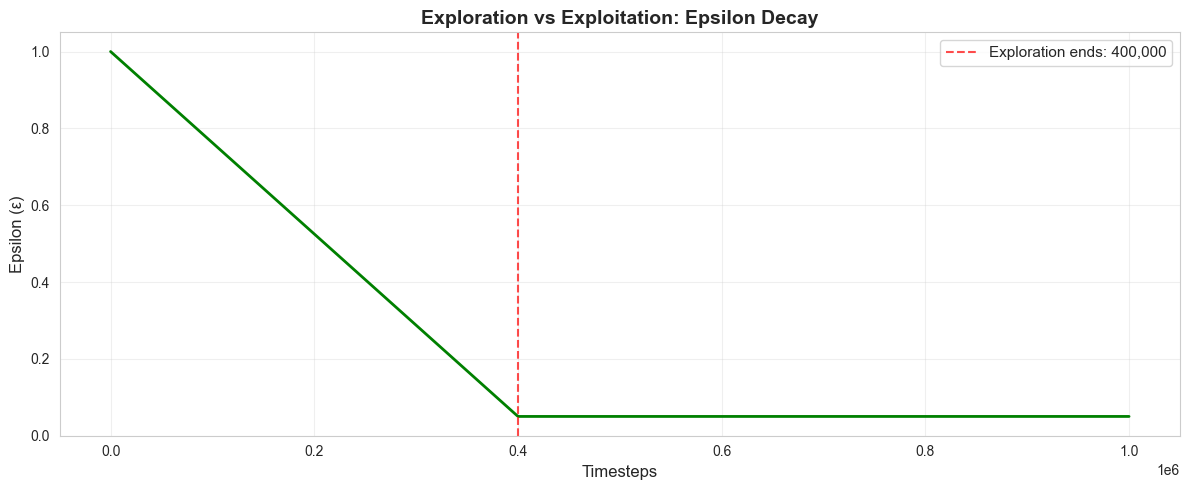

In [ ]:
# Epsilon Decay: Use agent hyperparameters
training_plots.plot_epsilon_decay(
    total_timesteps=TOTAL_TIMESTEPS,
    exploration_fraction=agent.hyperparams["exploration_fraction"],
    exploration_final_eps=agent.hyperparams["exploration_final_eps"],
    title="Exploration vs Exploitation: Epsilon Decay",
)

---
# Phase 2: Evaluation & Testing
Run N=100 independent test episodes with deterministic policy (ε=0).


In [9]:
# Run N=100 test episodes with deterministic policy
# Using pre-generated EVAL_SEEDS for reproducibility
N_TEST_EPISODES = len(EVAL_SEEDS)

reward_fn = RewardFunction()
# Storage for test results
test_episodes_dqn = []

print(f"🧪 Running {N_TEST_EPISODES} test episodes with deterministic seeds...")

for ep, seed in enumerate(EVAL_SEEDS):
    # DQN Agent Episode
    dqn_env = make_env(random_seed=seed)
    obs, _ = dqn_env.reset()

    dqn_data = {
        "net_inv_0": [],
        "net_inv_1": [],
        "q0": [],
        "q1": [],
        "demand_0": [],
        "demand_1": [],  # Daily demand per product
        "ordering_cost": [],
        "holding_cost": [],
        "shortage_cost": [],
        "total_daily_cost": [],
    }

    done = False
    while not done:
        action = agent.select_action(obs, deterministic=True)
        action_obj = dqn_env.action_space_config.get_action(action)
        obs, reward, terminated, truncated, info = dqn_env.step(action)

        # Log Inventory & Actions
        dqn_data["net_inv_0"].append(info["net_inventory"][0])
        dqn_data["net_inv_1"].append(info["net_inventory"][1])
        dqn_data["q0"].append(action_obj.order_quantities[0])
        dqn_data["q1"].append(action_obj.order_quantities[1])

        # Log Daily Demand per product
        dqn_data["demand_0"].append(info["total_demand"][0])
        dqn_data["demand_1"].append(info["total_demand"][1])

        # Compute Daily Cost Components using RewardFunction
        state = State(
            net_inventory=tuple(info["net_inventory"]),
            outstanding_orders=tuple(info["outstanding"]),
        )
        costs = reward_fn.calculate_costs(state, action_obj)

        # Append to lists
        dqn_data["ordering_cost"].append(costs.ordering_cost)
        dqn_data["holding_cost"].append(costs.holding_cost)
        dqn_data["shortage_cost"].append(costs.shortage_cost)
        dqn_data["total_daily_cost"].append(costs.total_cost)

        done = terminated or truncated

    test_episodes_dqn.append(dqn_data)

print(f"✅ Collected {N_TEST_EPISODES} test episodes for DQN")
print(f"   Seeds used: {EVAL_SEEDS[0]} to {EVAL_SEEDS[-1]}")
print(f"   All seeds are deterministic and saved for reproducibility")

🧪 Running 100 test episodes with deterministic seeds...
✅ Collected 100 test episodes for DQN
   Seeds used: 2216 to 2415
   All seeds are deterministic and saved for reproducibility


### Warm-up Period Analysis (Welch's Graphical Procedure)
Since the simulation starts with initial inventory conditions, the early data may be biased (transient phase). 
We use Welch's procedure to identify when steady-state begins.

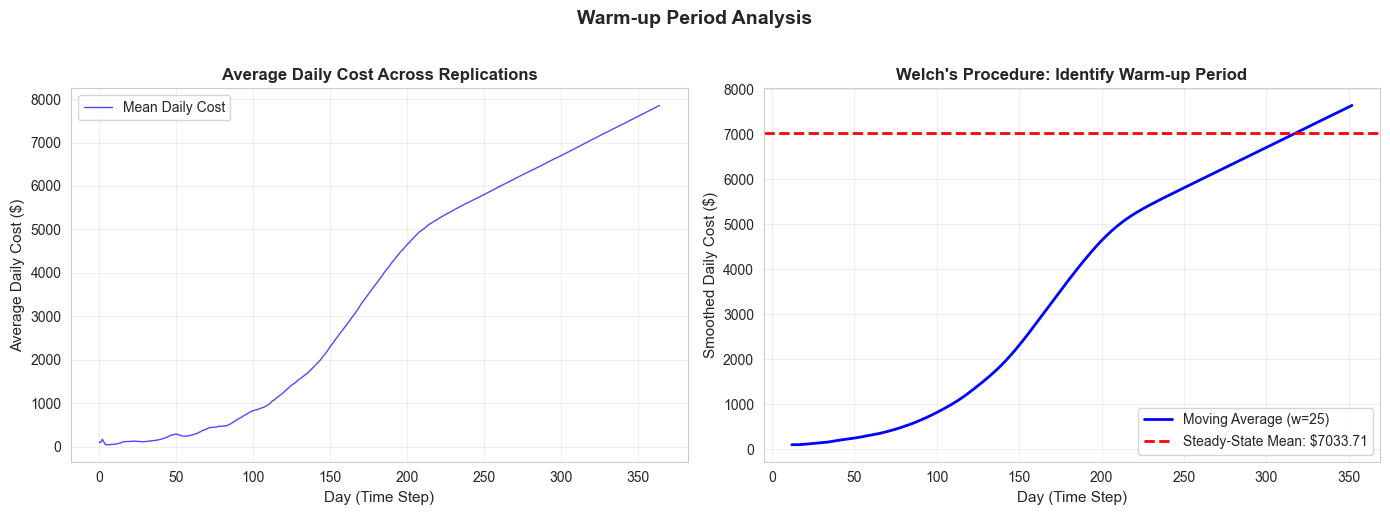

📊 Welch's Procedure Summary:
   Total replications: 100
   Episode length:     365 days
   Moving average window:    25

📈 Results & Convergence:
   Steady-State Mean: $7033.71
   Stability (Std Dev):    353.56 (Lower is better/flatter)

⚠️  Visually inspect the right plot to identify where the curve flattens.


In [10]:
# Welch's Graphical Procedure for Warm-up Detection
n_days, n_reps = evaluation_plots.plot_welch_procedure(
    test_episodes=test_episodes_dqn,
    window_size=25,
    title="Warm-up Period Analysis",
)

In [11]:
# Set warm-up length based on visual inspection of Welch's plot
# Adjust this value based on where the curve flattens
WARMUP_LENGTH = 75  # days to discard from beginning of each episode

print(f"✅ Warm-up length set to {WARMUP_LENGTH} days")
print(f"   Steady-state analysis will use days {WARMUP_LENGTH+1} to {n_days}")
print(f"   Effective data per episode: {n_days - WARMUP_LENGTH} days")

✅ Warm-up length set to 75 days
   Steady-state analysis will use days 76 to 365
   Effective data per episode: 290 days


### 3. Cost Component Breakdown (Economic Analysis)
Grouped bar chart
 decomposed into Ordering, Holding, and Shortage costs.

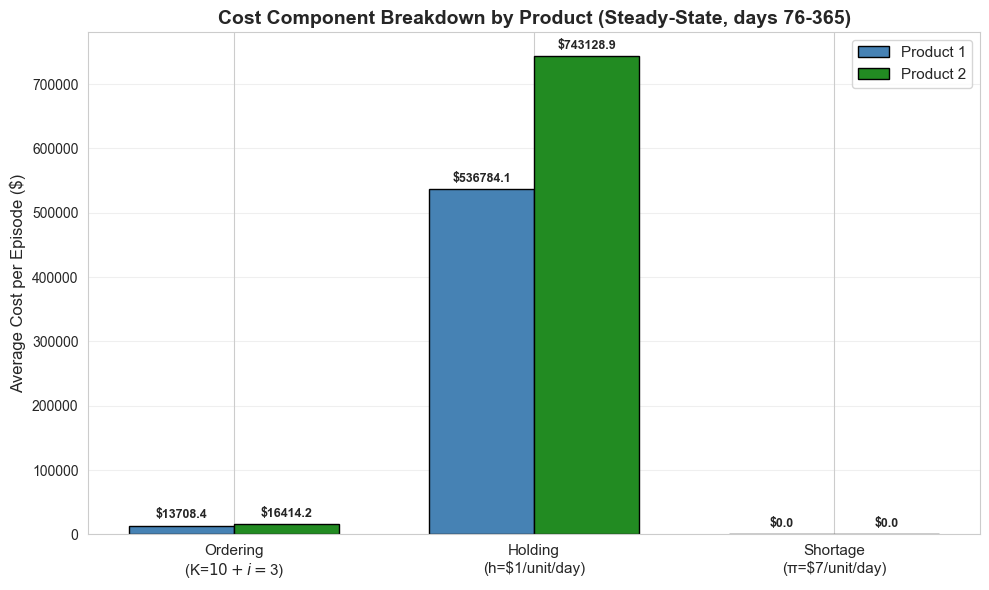

📊 Steady-State Average Cost per Episode (days 76-365):

  Product 1: $550492.46
    Ordering: $13708.37 (2.5%)
    Holding:  $536784.09 (97.5%)
    Shortage: $0.00 (0.0%)

  Product 2: $759543.19
    Ordering: $16414.25 (2.2%)
    Holding:  $743128.94 (97.8%)
    Shortage: $0.00 (0.0%)

------------------------------------------------------------

  TOTAL: $1310035.65


In [12]:
# Cost Component Breakdown by Product
evaluation_plots.plot_cost_breakdown_by_product(
    test_episodes=test_episodes_dqn,
    warmup_length=WARMUP_LENGTH,
    n_days=n_days,
    title="Cost Component Breakdown by Product",
)

### 4. Operational Time Series (Behavioral Analysis)
Snapshot of 100 days showing Net Inventory and Replenishment Actions for Product 1 and Product 2.


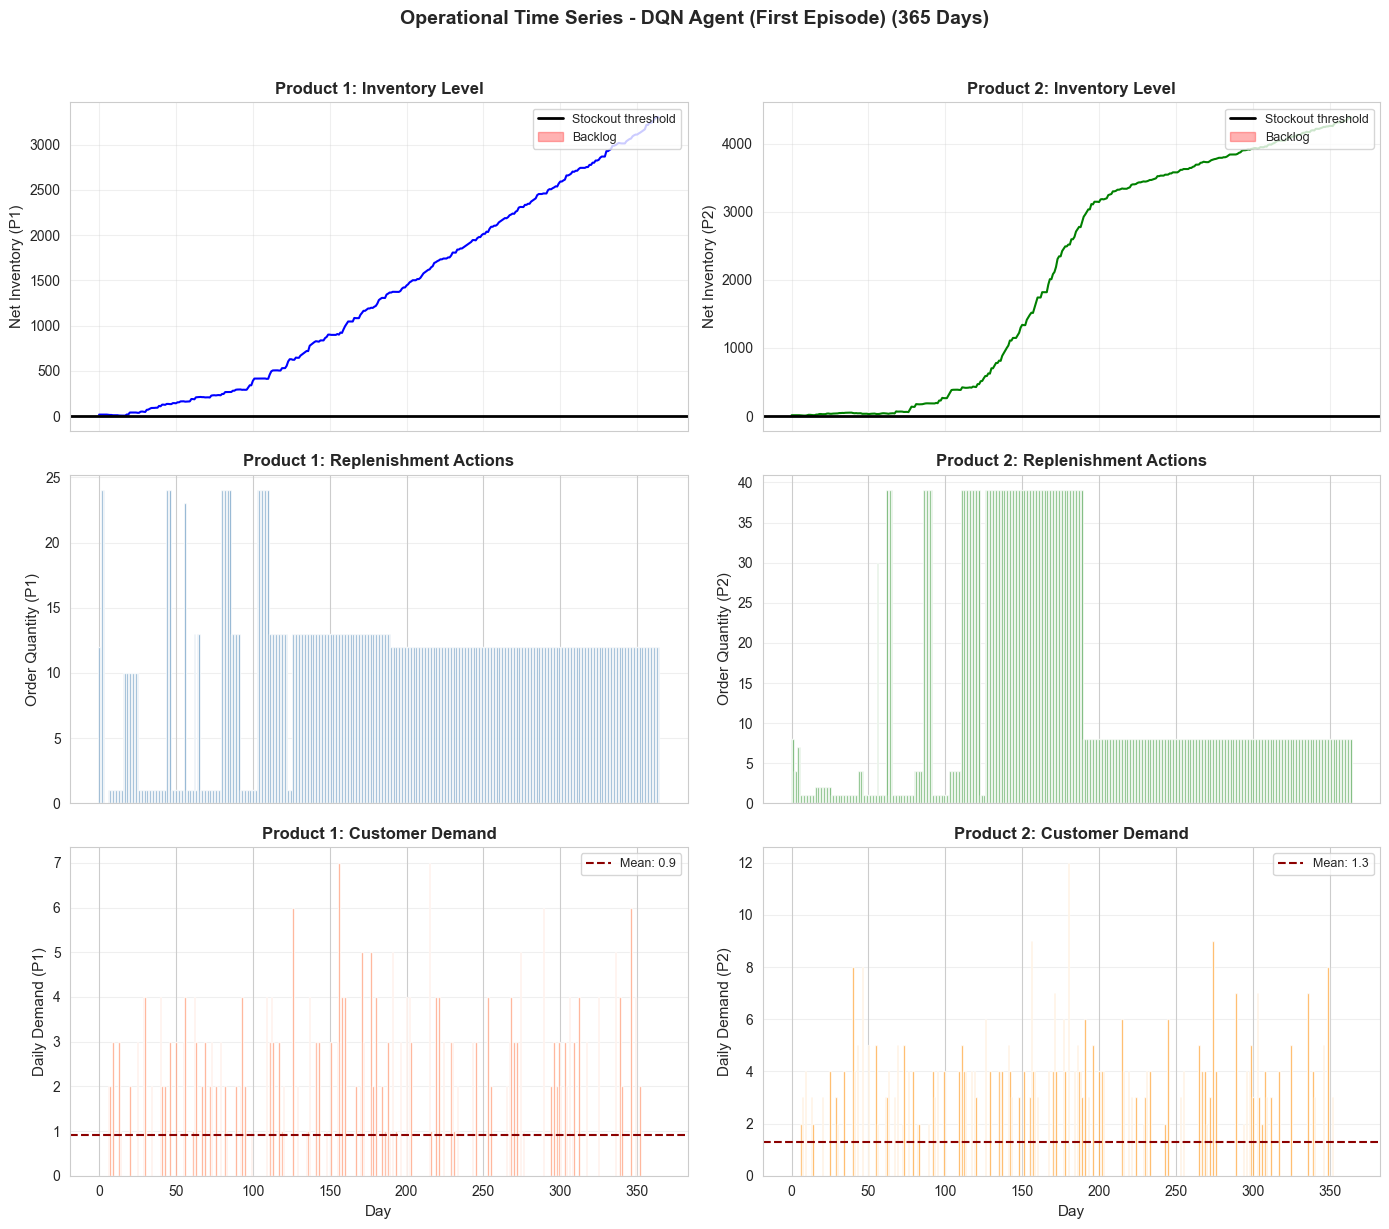

In [13]:
# Select representative episode (closest to mean total cost)
# episode_avg_costs = [np.mean(ep['total_daily_cost']) for ep in test_episodes_dqn]
# global_mean_cost = np.mean(episode_avg_costs)
# representative_idx = np.argmin(np.abs(np.array(episode_avg_costs) - global_mean_cost))

# print(f"📊 Representative episode: {representative_idx} (avg cost: {episode_avg_costs[representative_idx]:.2f}, global mean: {global_mean_cost:.2f})")

# Operational Time Series - Use the first episode
evaluation_plots.plot_operational_timeseries(
    episode_data=test_episodes_dqn[0],
    title="Operational Time Series - DQN Agent (First Episode)",
)

### 5. Inventory Distribution Histogram (Risk Profile)
Distribution of Net Inventory levels over all test episodes. Red = Backlog (I < 0), Green = On-Hand (I > 0).


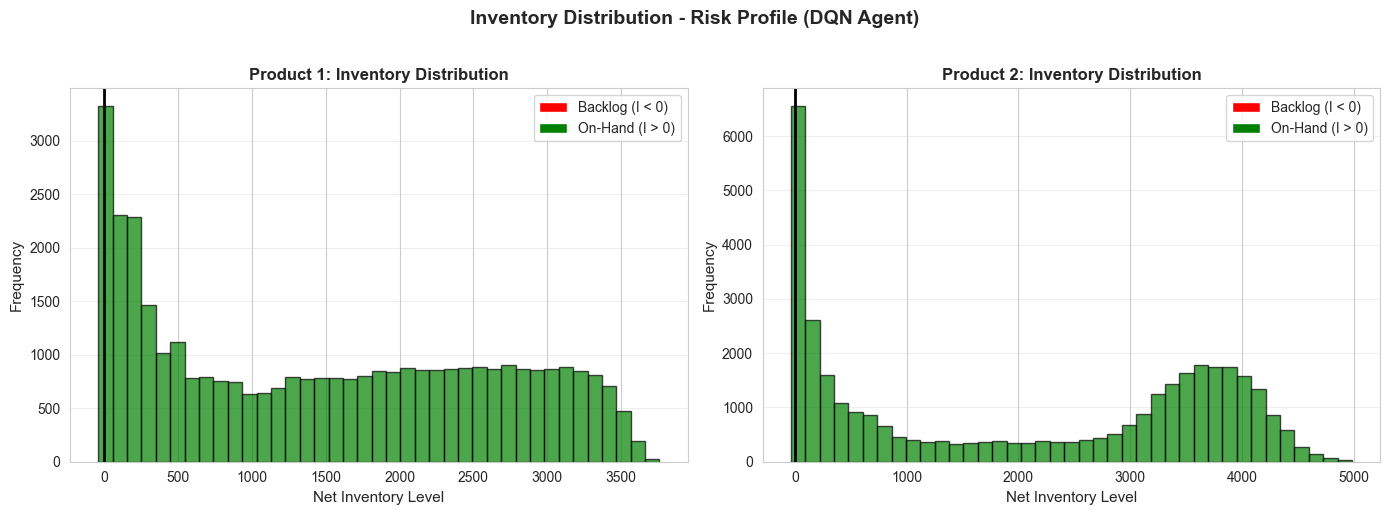

⚙️Service Level (% days without stockout):
  Product 1: 98.2%
  Product 2: 99.1%


In [14]:
# Inventory Distribution Histogram
evaluation_plots.plot_inventory_histogram(
    test_episodes=test_episodes_dqn,
    title="Inventory Distribution - Risk Profile (DQN Agent)",
)